In [2]:
"""
Description:
    Draft code for producing detailed plots of cross-correlation results 
    that are stored in netCDF files. A single pdf file containing plots
    for each station-pair is output when the notebook runs to completion.
References:

CreationDate:   09/08/18
Developer:      rakib.hassan@ga.gov.au

Revision History:
    LastUpdate:     09/08/18   RH
    LastUpdate:     dd/mm/yyyy  Who     Optional description
"""

import sys, os, math
import numpy as np
import scipy
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
from shapely.geometry import Polygon
from matplotlib.patches import Ellipse
from collections import defaultdict

from netCDF4 import Dataset as NCDataset
from obspy.core import Stream, UTCDateTime

sys.path.append('/g/data/ha3/rakib/seismic/pst/passive-seismic')
from xcorqc.correlator import Dataset

import matplotlib.dates as mdates
import datetime
from textwrap import wrap
from matplotlib.backends.backend_pdf import PdfPages
import gc

%matplotlib inline

PERM_STATION_NAME = 'QLP'
CORR_PATH = '/g/data/ha3/rakib/xcorTest/7G/'

TIME_WINDOW = 300 # +/-
SNR_THRESHOLD = 7

/apps/matplotlib/1.5.1-py2.7/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
ds1 = Dataset('/g/data/ha3/Passive/_ANU/7G(2013-2015)/ASDF/7G(2013-2015).h5')
ds2 = Dataset('/g/data/ha3/rakib/_ANU/7G(2013-2015)/refData/7G.refdata.h5')
corrFiles = glob.glob(CORR_PATH + '/*.%s.nc'%(PERM_STATION_NAME))

centre: 143.330734, -29.030768


/apps/matplotlib/1.5.1-py2.7/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


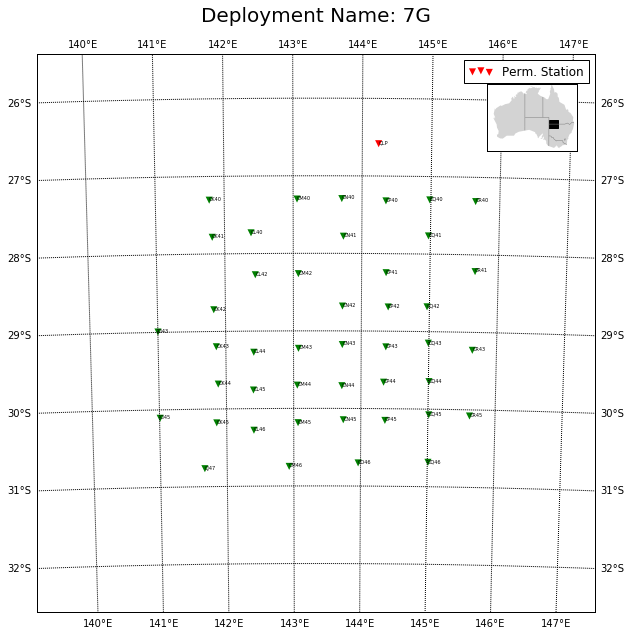

In [3]:
pdf = PdfPages('7G.pdf')

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d
# end func

def drawBBox( minLon, minLat, maxLon, maxLat, bm, **kwargs):
    bblons = np.array([minLon, maxLon, maxLon, minLon, minLon])
    bblats = np.array([minLat, minLat, maxLat, maxLat, minLat])
    
    x, y = bm( bblons, bblats )
    xy = zip(x,y)
    poly = Polygon(xy)
    bm.ax.add_patch(PolygonPatch(poly, **kwargs))
#end func

fig = plt.figure(figsize=(10,10))

minLon = 1e32
maxLon = -1e32
minLat = 1e32
maxLat = -1e32
for s in ds1.stations:
    lon,lat = ds1.stations_metadata[s].coordinates['longitude'], \
              ds1.stations_metadata[s].coordinates['latitude']
    
    if(minLon > lon): minLon = lon
    if(maxLon < lon): maxLon = lon
    if(minLat > lat): minLat = lat
    if(maxLat < lat): maxLat = lat        
# end for

m = Basemap(width=800000,height=800000,projection='lcc',
            resolution='l',lat_1=minLat,lat_2=maxLat,
            lat_0=(minLat+maxLat)/2., lon_0=(minLon + maxLon)/2.)
# draw coastlines.
m.drawcoastlines()

#draw grid
parallels = np.linspace(np.floor(minLat)-5, np.ceil(maxLat)+5, \
                        int((np.ceil(maxLat)+5) - (np.floor(minLat)-5))+1)
m.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.linspace(np.floor(minLon)-5, np.ceil(maxLon)+5, \
                        int((np.ceil(maxLon)+5) - (np.floor(minLon)-5))+1)
m.drawmeridians(meridians,labels=[False,False,True,True])

# plot stations
for s in ds1.stations:
    lon,lat = ds1.stations_metadata[s].coordinates['longitude'], \
              ds1.stations_metadata[s].coordinates['latitude']

    px,py = m(lon, lat)
    pxl,pyl = m(lon, lat-0.1)
    m.scatter(px, py, 50, marker='v', c='g', edgecolor='none')    
    plt.annotate(s, xy=(px, py), fontsize=5)
# end for

# plot stations
for s in ds2.stations:
    lon,lat = ds2.stations_metadata[s].coordinates['longitude'], \
              ds2.stations_metadata[s].coordinates['latitude']

    px,py = m(lon, lat)
    pxl,pyl = m(lon, lat-0.1)
    m.scatter(px, py, 50, marker='v', c='r', edgecolor='none', label='Perm. Station')    
    plt.annotate(s, xy=(px, py), fontsize=5)
# end for

insetAx = fig.add_axes([0.75,0.75,0.125,0.125])
mInset = Basemap(resolution='c', # c, l, i, h, f or None
            ax=insetAx,
            projection='merc',
            lat_0=-20, lon_0=132,
            llcrnrlon=110, llcrnrlat=-40, urcrnrlon=155, urcrnrlat=-10)
#mInset.drawcoastlines()
mInset.fillcontinents(color='lightgray')
mInset.drawstates(color="grey")

drawBBox(minLon, minLat, maxLon, maxLat, mInset, fill='True', facecolor='k')

print 'centre: %lf, %lf'%(np.mean([minLon, maxLon]), np.mean([minLat, maxLat]))

fig.axes[0].set_title("Deployment Name: 7G", fontsize = 20, y=1.05)
fig.axes[0].legend()
plt.legend()
plt.savefig('./stations-perm.pdf')

pdf.savefig()

In [4]:
for fn in corrFiles:
    #if 'CJ47.QLP' not in fn: continue

    pair = os.path.basename(fn)
    
    sn = pair.split('.')[0]
    print 'Processing station: %s..'%sn
    
    origin = (ds1.stations_metadata[sn].coordinates['latitude'], 
              ds1.stations_metadata[sn].coordinates['longitude'])
    dest = (ds2.stations_metadata[PERM_STATION_NAME].coordinates['latitude'], 
            ds2.stations_metadata[PERM_STATION_NAME].coordinates['longitude'])
    
    d = distance(origin, dest)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Station: %s, Dist. to %s: %3.2f km"%(sn, PERM_STATION_NAME, d), 
                 fontsize = 16, y=1)

    ax1 = fig.add_axes([0.1, 0.075, 0.5, 0.725])
    cax1 = fig.add_axes([0.125, 0.7, 0.015, 0.05])

    labelPad = 0.05
    ax2 = fig.add_axes([0.1, 0.8, 0.5, 0.175])
    ax3 = fig.add_axes([0.6, 0.075, 0.1, 0.725]) # stacked windows
    ax4 = fig.add_axes([0.6+labelPad, 0.8+labelPad, 0.345, 0.175-labelPad]) # histogram
    ax5 = fig.add_axes([0.7, 0.075, 0.1, 0.725]) # C3
    ax6 = fig.add_axes([0.8, 0.075, 0.195, 0.725]) # timeshifts

    # read data ==================
    d = NCDataset(fn, 'r')
    
    sTimes = d.variables['IntervalStartTimes'][:]
    lag = d.variables['lag'][:]
    xcorr = d.variables['xcorr'][:, :]    
    nStackedWindows = d.variables['NumStackedWindows'][:]
    d.close()
    d = None

    ccfDict = defaultdict(list)
    
    lagIndices = np.squeeze(np.argwhere(np.fabs(np.round(lag, decimals=2)) == TIME_WINDOW))
    #print lagIndices, lag[lagIndices]
    ccfDict[pair] = {'start-times':sTimes, 
                     'lag':lag[lagIndices[0]:lagIndices[1]], 
                     'ccf':xcorr[:, lagIndices[0]:lagIndices[1]],
                     'nsw':nStackedWindows}            
    
    sTimes = ccfDict[pair]['start-times']
    lag = ccfDict[pair]['lag']
    ccf = ccfDict[pair]['ccf']
    
    # Plot CCF image =======================
    gx, gy = np.meshgrid(lag, sTimes)
    
    #print gx.shape
    #print xcorr.shape
        
    im = ax1.pcolormesh(gx, gy, ccf, 
                        cmap='RdYlBu_r', vmin=0, vmax=1, rasterized=True)
    
    t = np.array(sTimes)
    g = np.gradient(t)
    indices = np.argwhere(g > (np.mean(g) + 2*np.std(g)))
    
    if (len(indices)>1):
        for i,idx in enumerate(indices[::2]):
            bx = np.array([np.min(gx), np.max(gx), np.max(gx), np.min(gx), np.min(gx)])
            by = np.array([sTimes[idx], sTimes[idx], sTimes[indices[i+1]], sTimes[indices[i+1]], sTimes[idx]])

            xy = zip(bx,by)
            poly = Polygon(xy)
            #ax1.add_patch(PolygonPatch(poly, facecolor='white', ec='red'))
        # end for
    # end if

    labels=[]
    for st in sTimes: labels.append(UTCDateTime(st).strftime("%y-%m-%d"))
    ax1.set_yticks(sTimes[::7])
    ax1.set_yticklabels(labels[::7])
    ax1.set_xlabel('Lag [s]')
    ax1.set_ylabel('Days')

    fig.colorbar(im, cax=cax1, orientation='vertical', ticks=[0, 1])
    
    # Plot CCF-template =====================
    rowMask = (np.sum(ccf, axis=1)>0)
    mask = np.ones_like(ccf)
    for i in range(len(rowMask)):
        mask[i,:] *= rowMask[i] 
    
    ccfMasked = np.ma.masked_array(ccf, mask=~np.bool_(mask))
    snr = np.nanmax(ccfMasked, axis=1) / np.nanstd(ccfMasked, axis=1)    
    
    rcf = np.nanmean(ccfMasked[snr>SNR_THRESHOLD, :], axis=0)
    ax2.axvline(lag[np.argmax(rcf)], c='#c66da9', lw=2,
                label = '%5.2f s'%(lag[np.argmax(rcf)]))
    ax2.plot(lag, rcf, c='#42b3f4', 
             label=r"Reference CCF "
                    "\n"
                    "Based on Subset "
                    "\n"
                    "with SNR > %d"%SNR_THRESHOLD)
    ax2.set_xticklabels([])
    ax2.legend()
        
    # Plot number of stacked windows ==============
    ax3.plot(ccfDict[pair]['nsw'], sTimes, c='#529664')
    ax3.set_yticklabels([])
    ax3.set_xlabel('\n'.join(wrap('# of Hourly Stacked Windows', 12)))
    xtl = ax3.get_xticklabels()
    xtl[0].set_visible(False)
    xtl[-1].set_visible(False)
    
    # Plot histogram
    ax4.hist(snr.compressed(), fc='#42b3f4', ec='none', bins=10)
    ax4.set_xlabel('SNR: Daily CCFs [-%d, %d]s'%(TIME_WINDOW, TIME_WINDOW))
    ax4.set_ylabel('Frequency')
    xtl = ax4.get_xticklabels()
    xtl[0].set_visible(False)
    xtl[-1].set_visible(False)
    
    # plot cc ===================
    # Compute CCave
    cc = []
    for row in ccfMasked:
        if(np.ma.is_masked(row)): 
            cc.append(0)
            continue
            
        pcf, _ = scipy.stats.pearsonr(rcf, row)
        cc.append(pcf)
    # end for
    cc = np.array(cc)
    ccav = np.mean(np.ma.masked_array(cc, mask=cc==0))
    
    ax5.plot(cc, sTimes, c='#d37f26')
    ax5.set_yticklabels([])
    ax5.set_xticks([0,1])
    ax5.set_xlabel('\n'.join(wrap('Pearson Coeff. (RCF * CCF)', 15)))
    ax5.text(0.5, 0.95, '$CC_{ave}$=%3.3f'%ccav, horizontalalignment='center', \
             verticalalignment='center', transform=ax5.transAxes)
    
    # plot Timeshift =====================    
    corr = []
    for i, row in enumerate(ccfMasked):
        if(np.ma.is_masked(row)): 
            corr.append(0)
            continue
        
        if(cc[i] < 0.85*ccav):
            corr.append(0)
            continue
            
        c3 = scipy.signal.correlate(rcf, row, mode='same')
        c3 /= np.max(c3)
        lag = ccfDict[pair]['lag'][np.argmax(c3)]
        corr.append(lag)    
    # end for
    corr = np.array(corr)
    ax6.plot(corr, sTimes, c='#f22e62', lw=1.5)
    ax6.set_yticklabels([])
    xtl = ax6.get_xticklabels()
    xtl[0].set_visible(False)
    xtl[-1].set_visible(False)
    ax6.set_xlabel('\n'.join(wrap('Estimated Timeshift [s]: RCF * CCF', 15)))

    pdf.savefig(fig)
    fig.clf()
    plt.close()
    ccfDict = None
    
    gc.collect(2)    
# end for

pdf.close()

Processing station: CL45..
Processing station: CP42..
Processing station: CN41..
Processing station: CM43..
Processing station: CM42..
Processing station: CK45..
Processing station: CM40..
Processing station: CL42..
Processing station: CL40..


/g/data/ha3/rakib/soft/.local/lib/python2.7/site-packages/numpy-1.14.1-py2.7-linux-x86_64.egg/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Processing station: CK42..
Processing station: CN42..
Processing station: CR41..
Processing station: CN45..
Processing station: CK41..
Processing station: CO46..
Processing station: CL46..
Processing station: CI45..
Processing station: CP41..
Processing station: CR40..
Processing station: CP43..
Processing station: CN44..
Processing station: CK43..
Processing station: CM44..
Processing station: CN43..
Processing station: CQ44..
Processing station: CR45..
Processing station: CQ46..
Processing station: CQ40..
Processing station: CR43..
Processing station: CQ45..
Processing station: CP40..
Processing station: CI43..
Processing station: CM46..
Processing station: CQ43..
Processing station: CL44..
Processing station: CQ42..
Processing station: CQ41..
Processing station: CP44..
Processing station: CJ47..
Processing station: CK44..
Processing station: CK40..
Processing station: CP45..
Processing station: CM45..
Processing station: CN40..
